# Overview:
- Your goal is to predict the values of single unit properties using the observations from 2017.
- In these exercises, you will run through the stages of exploration as you continue to work toward the above goal. 
- Use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

# Exercise requiremnets: 
1. Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

2. Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

3. Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

4. Use the functions you created above to explore your Zillow train dataset in your explore.ipynb notebook.

5. Come up with some initial hypotheses based on your goal of predicting property value.

6. Visualize all combinations of variables in some way.

7. Run the appropriate statistical tests where needed.

8. What independent variables are correlated with the dependent variable, home value?

9. Which independent variables are correlated with other independent variables (bedrooms, bathrooms, year built, square feet)?

10. Make sure to document your takeaways from visualizations and statistical tests as well as the decisions you make throughout your process.

11. Explore your dataset with any other visualizations you think will be helpful.

In [23]:
# imports: 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
import scipy.stats as stats

import wrangle as wr

## Aquiure and Prepare the data: 

In [2]:
# get the data: 
df = wr.create_zillow_data()
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [3]:
# prep the data:
df = wr.prep_zillow(df)
df.head()

,bedrooms,bathrooms,area,taxvalue,yearbuilt,taxamount,county
4,4,2.0,3633,296425,2005,6941.39,LA
6,3,4.0,1620,847770,2011,10244.94,LA
7,3,2.0,2077,646760,1926,7924.68,LA
11,0,0.0,1200,5328,1972,91.60,LA
14,0,0.0,171,6920,1973,255.17,LA


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140235 entries, 4 to 2152862
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   bedrooms   int64  
 1   bathrooms  float64
 2   area       int64  
 3   taxvalue   int64  
 4   yearbuilt  int64  
 5   taxamount  float64
 6   county     object 
dtypes: float64(2), int64(4), object(1)
memory usage: 130.6+ MB


In [5]:
# split the data: 
train, validate, test = wr.split_zillow_data(df)
train.head()

,bedrooms,bathrooms,area,taxvalue,yearbuilt,taxamount,county
1567873,3,1.0,1248,191578,1950,2712.21,LA
1218138,2,2.0,1326,1345206,1950,16539.04,LA
339661,2,1.0,1053,356648,1953,4575.16,LA
1017133,3,2.0,1256,175069,1946,2635.51,LA
40250,3,2.0,1640,543000,1957,6344.96,Orange


In [6]:
# scale the columns using minmaxscaler
from sklearn.preprocessing import StandardScaler

In [7]:
to_scale = ['bedrooms', 'bathrooms', 'area', 'yearbuilt', 'taxamount']

In [8]:
# create the object: 
train_scaled = train.copy()
scaler = StandardScaler()

In [9]:
# fit and transform the object
train_scaled[to_scale] = scaler.fit_transform(train[to_scale])

In [10]:
# use the object
train_scaled.head()

,bedrooms,bathrooms,area,taxvalue,yearbuilt,taxamount,county
1567873,-0.323211,-1.250727,-0.443087,191578,-0.494672,-0.366887,LA
1218138,-1.395264,-0.242709,-0.387015,1345206,-0.494672,1.374494,LA
339661,-1.395264,-1.250727,-0.583269,356648,-0.359191,-0.132263,LA
1017133,-0.323211,-0.242709,-0.437336,175069,-0.675313,-0.376547,LA
40250,-0.323211,-0.242709,-0.161286,543000,-0.178550,0.090629,Orange


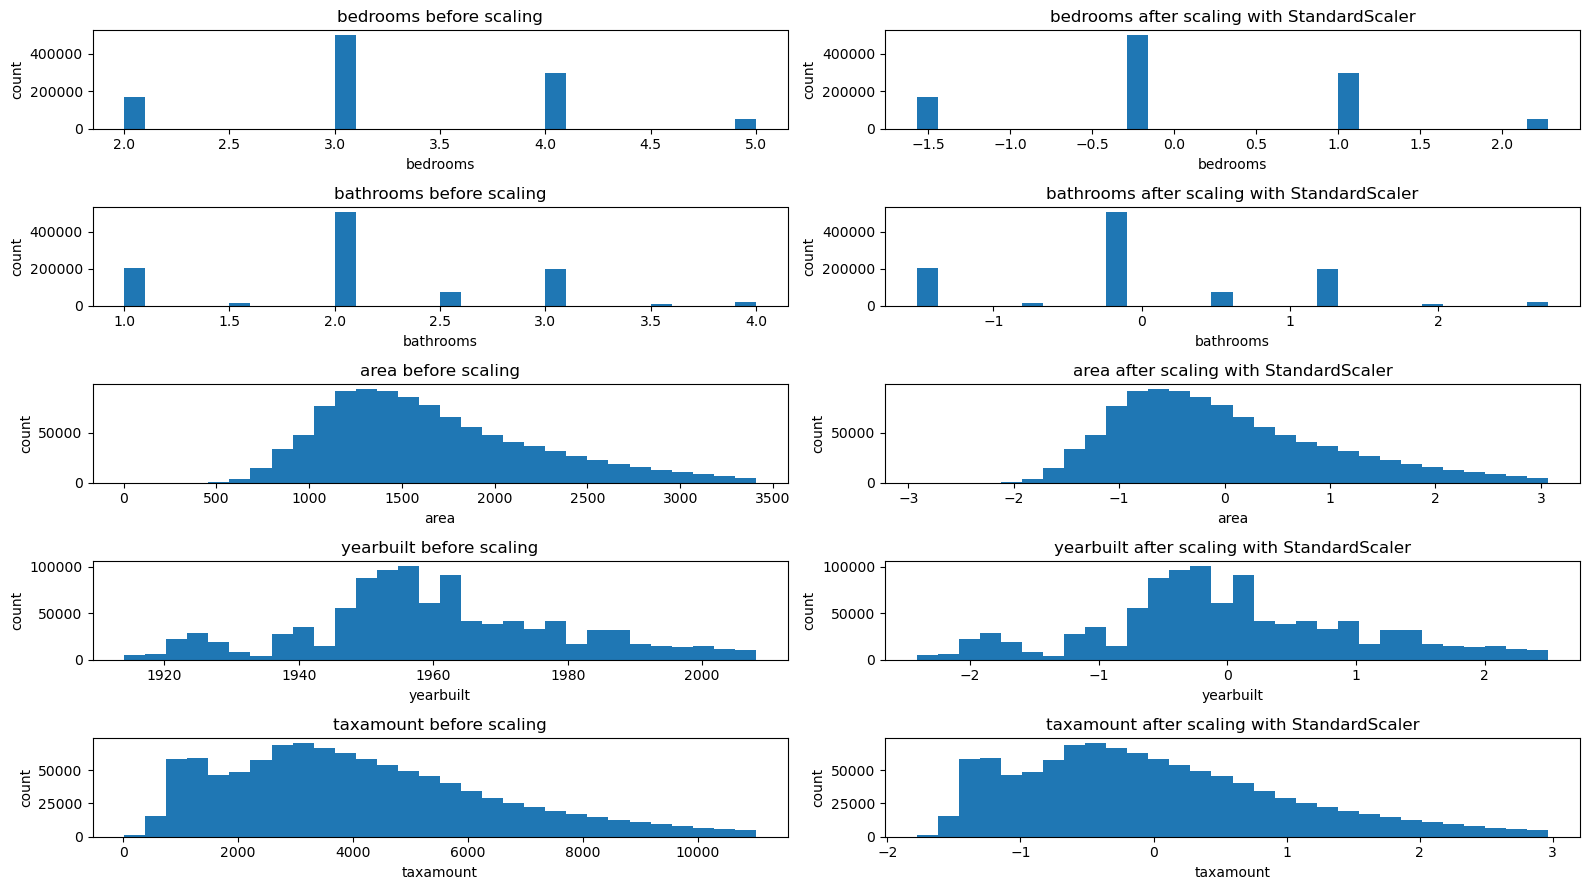

In [25]:
# look at the visualizations: 
import explore as ex
ex.visualize_scaler(scaler=StandardScaler(),
                   df = train,
                   columns_to_scale = to_scale,
                   bins = 30)

Distribution of bedrooms


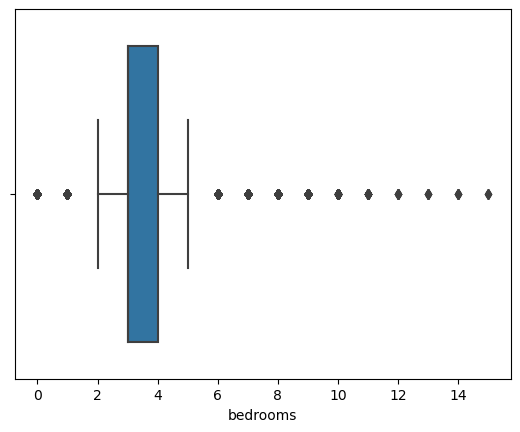

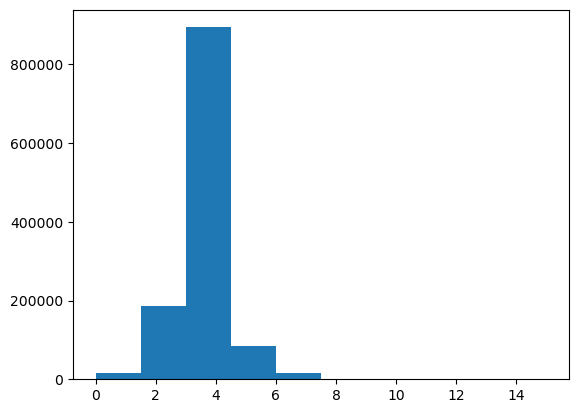

Distribution of bathrooms


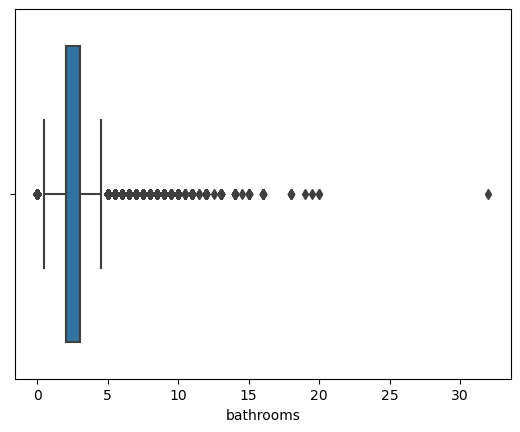

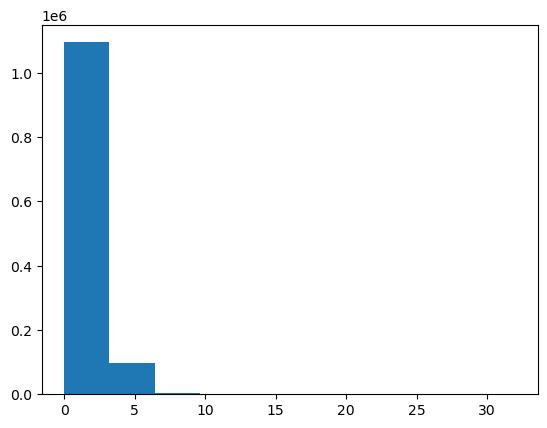

Distribution of area


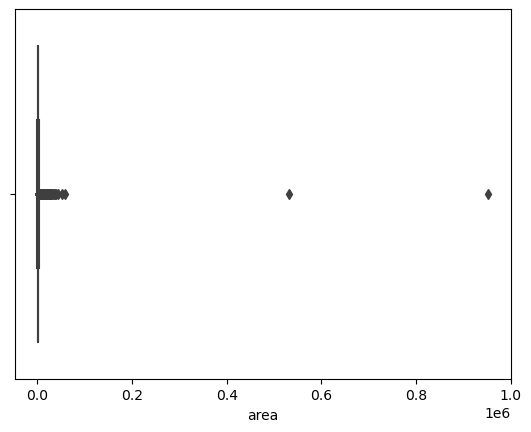

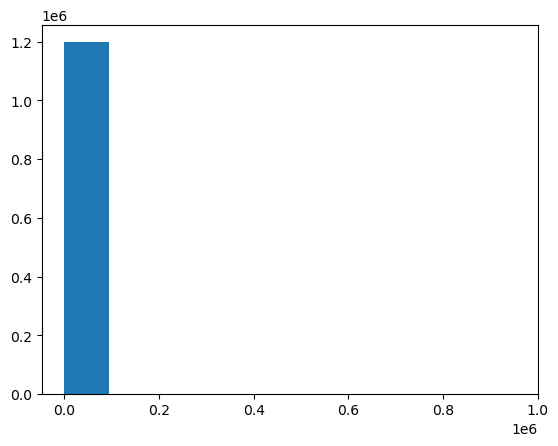

Distribution of yearbuilt


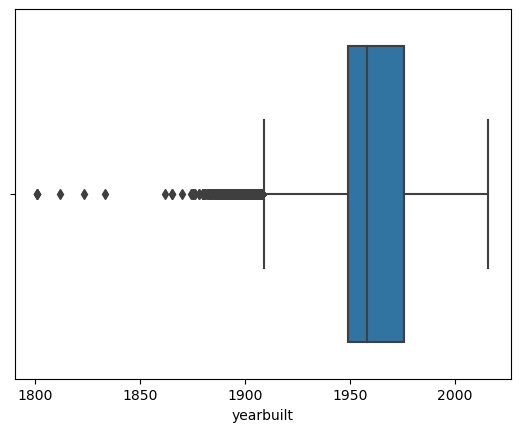

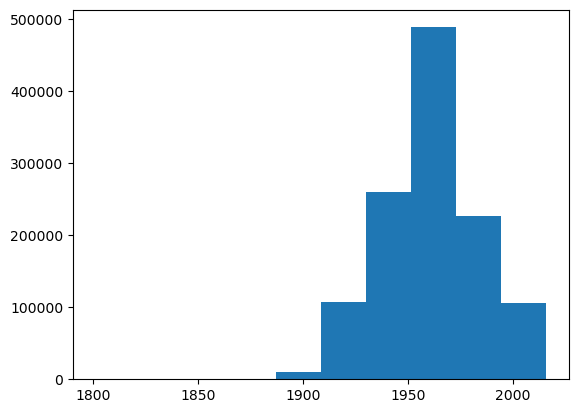

Distribution of taxamount


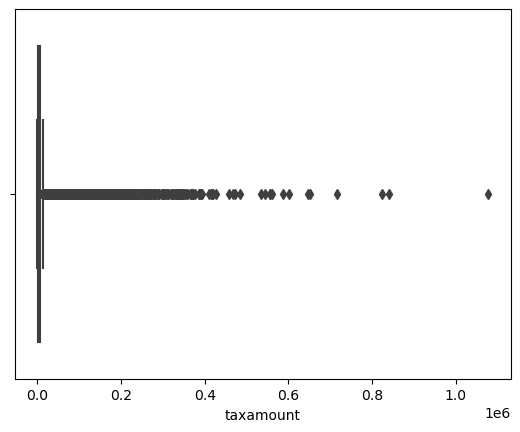

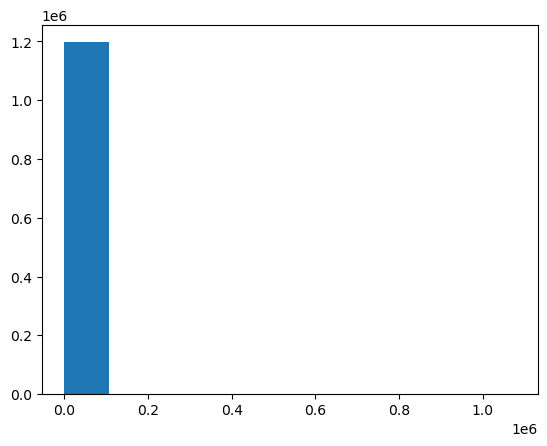

In [12]:
# I want to look for outliers in these columns
columns = ['bedrooms','bathrooms','area','yearbuilt','taxamount']
for col in columns:
    # print out a report header with the column name
    print(f'Distribution of {col}')
    # present a box plot of the information
    # (gives good info about where outliers sit)
    sns.boxplot(data=train, x=col)
    plt.show()
    # present a histogram
    # histogram will establish how Normal our distribution is
    plt.hist(train[col])
    plt.show()
    print('===================')

In [13]:
# want to remove the outlies
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:
        
        # For each column, it calculates the first quartile (q1) and 
        #third quartile (q3) using the .quantile() method, where q1 
        #corresponds to the 25th percentile and q3 corresponds to the 75th percentile.
        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [14]:
train = remove_outliers(train, 1.5, columns)

## Initial Questions: 

1.  Could bedrooms and bathrooms play a part in tax values? Are they stronger influencers apart or togther?
2. Does area impact tax value the most?
3. Does how old the house matter towards the tax value? I would assume older house, due the condition that they may be in, require much more work and therefore will cost less.

# Explore the Univarite Data: 

In [15]:
train.head()

,bedrooms,bathrooms,area,taxvalue,yearbuilt,taxamount,county
1567873,3,1.0,1248,191578,1950,2712.21,LA
339661,2,1.0,1053,356648,1953,4575.16,LA
1017133,3,2.0,1256,175069,1946,2635.51,LA
40250,3,2.0,1640,543000,1957,6344.96,Orange
1100705,3,2.0,1134,139806,1983,2445.04,LA


In [26]:
#split data into categorical columns and numerical columns

In [40]:
cat_cols, num_cols = [], []
for col in train_scaled.columns:
    if train_scaled[col].dtype == 'O':
        cat_cols.append(col)
    else:
        if train_scaled[col].nunique() < 10:
            cat_cols.append(col)
        else:
            num_cols.append(col)


In [41]:
# categorical columns
cat_cols

['county']

In [42]:
# numerical columns:
num_cols

['bedrooms', 'bathrooms', 'area', 'taxvalue', 'yearbuilt', 'taxamount']

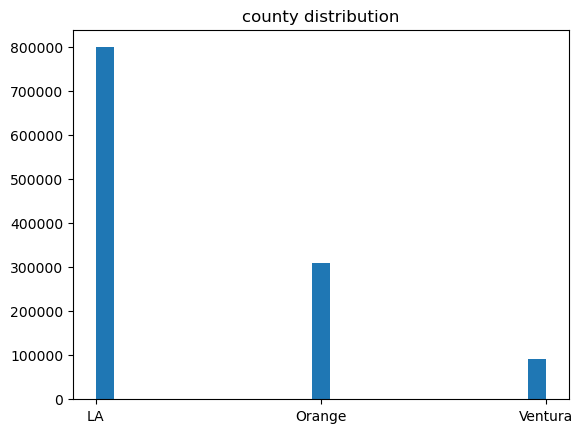

In [43]:
for col in cat_cols:

    
    plt.hist(train_scaled[col], bins=25)
    plt.title(f'{col} distribution')
    plt.show()

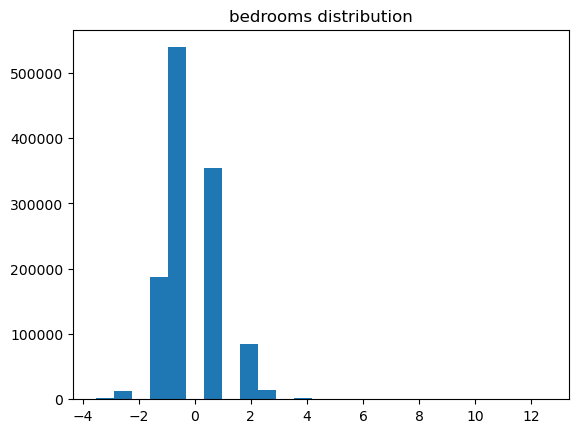

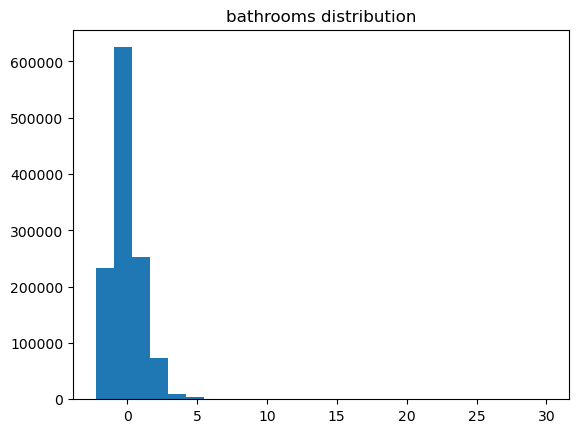

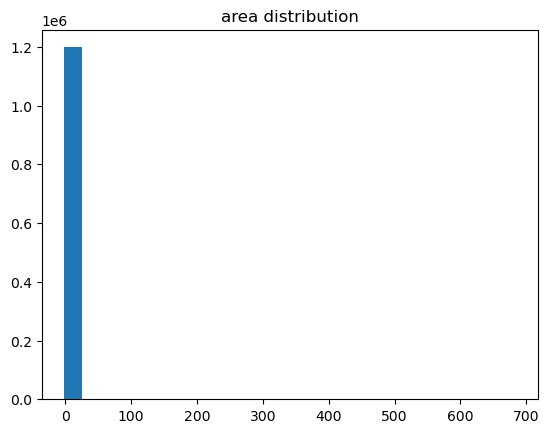

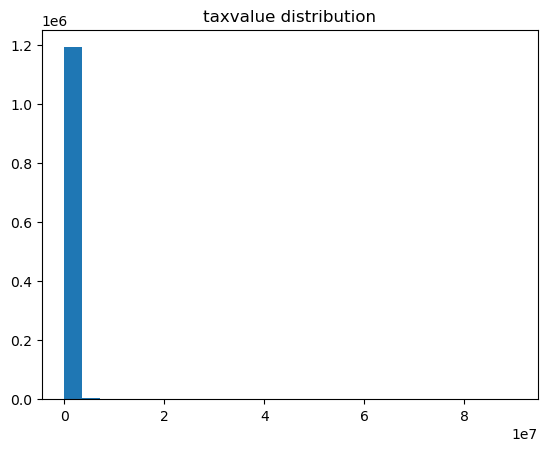

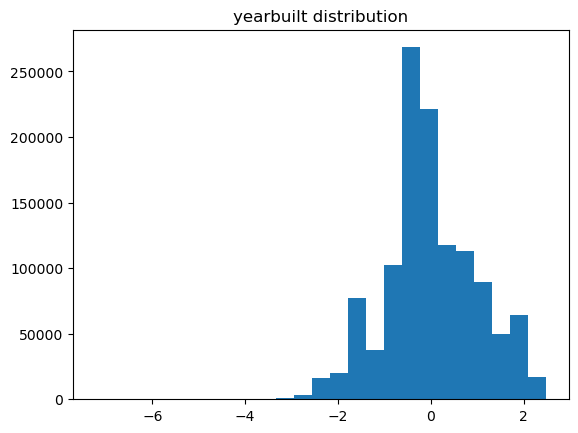

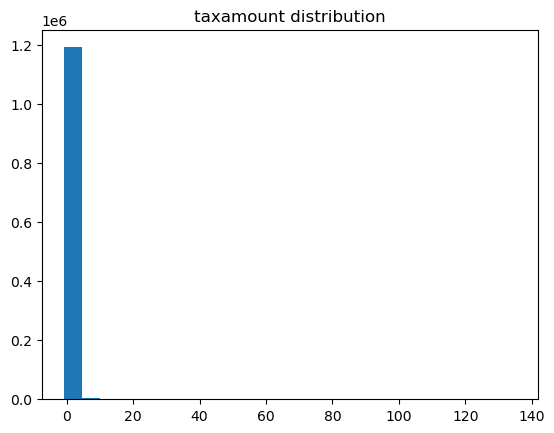

In [44]:
for col in num_cols:

    
    plt.hist(train_scaled[col], bins=25)
    plt.title(f'{col} distribution')
    plt.show()

In [45]:
X_train.describe()

,bedrooms,bathrooms,area,yearbuilt,taxamount
count,1.198531e+06,1.198531e+06,1.198531e+06,1.198531e+06,1.198531e+06
mean,6.604290e-18,9.115580e-17,-1.688422e-17,4.084777e-15,-3.532613e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.539369e+00,-2.258744e+00,-1.339531e+00,-7.223552e+00,-7.076706e-01
25%,-3.232113e-01,-2.427091e-01,-4.358984e-01,-5.398321e-01,-3.883542e-01
50%,-3.232113e-01,-2.427091e-01,-1.735071e-01,-1.333897e-01,-1.902597e-01
75%,7.488414e-01,7.653083e-01,2.470379e-01,6.794951e-01,9.946224e-02
max,1.254142e+01,2.999781e+01,6.834479e+02,2.485906e+00,1.350701e+02


### Takeaways: 
It seems like the data may be impacted by a large amount of outliers.
- A large amount of the houses are based is LA
- Common number of bedrooms is 3
- The majority of bathrooms are under 5
- The largest amount of houses are from 1950s
- Area and taxamount may have large outliers leading to the data only showing up in one column 

# Explore Bivariate and Multivarite

In [46]:
#correlation: 
train_corr = train_scaled[num_cols].corr(method='spearman')
train_corr

,bedrooms,bathrooms,area,taxvalue,yearbuilt,taxamount
bedrooms,1.000000,0.634836,0.655486,0.296015,0.425716,0.297600
bathrooms,0.634836,1.000000,0.826118,0.482150,0.569749,0.481831
area,0.655486,0.826118,1.000000,0.524060,0.511698,0.521719
taxvalue,0.296015,0.482150,0.524060,1.000000,0.290398,0.978622
yearbuilt,0.425716,0.569749,0.511698,0.290398,1.000000,0.289003
taxamount,0.297600,0.481831,0.521719,0.978622,0.289003,1.000000


<Axes: >

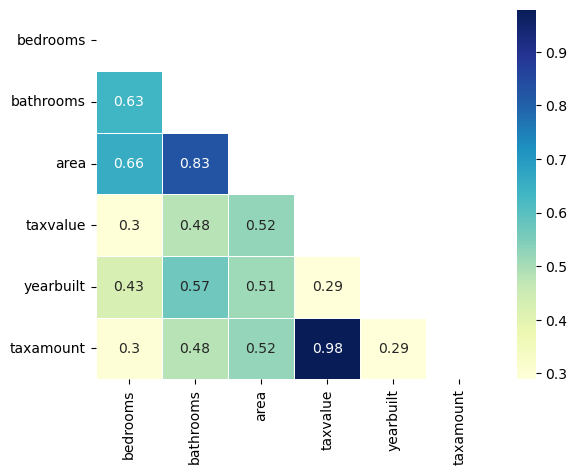

In [49]:
sns.heatmap(train_corr, cmap= 'YlGnBu', annot=True, linewidth=0.5,
           mask = np.triu(train_corr))

## Hypothesis: 
1. Is there a relationship between tax amount and tax value?
- $H_0$ : There is no linear correlation between taxamount and taxvalue
- $H_a$ : There is linear correlation between taxamount and taxvalue

In [50]:
α=0.05
r, p = spearmanr(train_scaled.taxvalue, train_scaled.taxamount)
if p < α:
        print(f"""We reject H₀, there is a monotonic relationship.
            Spearman’s r: {r:2f}
            P-value: {p}""")
else:
        print(f"""We fail to reject H₀: that there is a monotonic relationship.
                    Spearman’s r: {r:2f}
                    P-value: {p}""")


We reject H₀, there is a monotonic relationship.
            Spearman’s r: 0.978622
            P-value: 0.0


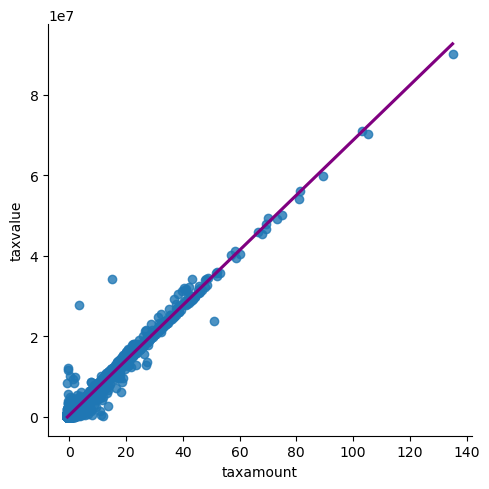

In [54]:
# make a lmplot:
sns.lmplot(data=train_scaled, x ='taxamount', y = 'taxvalue',
          line_kws={'color':'purple'})

#### Functions

In [55]:
def plot_variable_pairs(train, cont_var, cat_var):
# columns    
    cat_var = ['bedrooms', 'bathrooms', 'fips']
    cont_var = ['area', 'taxamount', 'tax_value', 'year_built']

#plots  
    sns.lmplot(x='tax_value', y='area', data=train.sample(1000), scatter=True)
    sns.lmplot(x='tax_value', y='year_built', data=train.sample(1000), scatter=True)
    sns.lmplot(x='tax_value', y='taxamount', data=train.sample(1000), scatter=True)


     
    return train, cont_var, cat_var

In [56]:
def plot_categorical_and_continuous_vars(train, cont_var, cat_var):
    
    # columns    
    cat_var = ['bedrooms', 'bathrooms', 'fips']
    cont_var = ['square_feet', 'tax_amount', 'tax_value', 'year_built']
    
    # plots
    sns.boxplot(x='bedrooms', y='tax_value', data=train.sample(1000))
    plt.show()
    sns.violinplot(x='bathrooms', y='tax_value', data=train.sample(1000))
    plt.show()
    sns.barplot(x='fips', y='tax_value', data=train.sample(1000))
    plt.show()
    
    return train, cont_var, cat_var
